# Detector de estrellas candidatas a HVS
En este notebook, se quiere explorar el uso de las fuentes de datos necesarias para el trabajo fin de master *Detecting Intermediate Mass Black Holes in globular clusters using Gaia Home*. Dichas fuentes de datos son:
- Gaia DR3
- XMMNewton (3XMM-DR8 catalogue)
- Chandra (Chandra Source Catalogue-CSC-R2)

Otro objetivo de este notebook es obtener un punto de partida recreando los resultados expuestos en [Tracing black holes in globular clusters with Gaia](https://santiago-ucm.atlassian.net/wiki/spaces/IMBH/overview?homepageId=98423) usando los resultados de DR3 en vex de DR2.


Usaremos astropy  y astroquery para la explotación de las bases de datos. De manera adicional, para la obtención de las coordenadas de los cúmulos globulares usaremos el catálogo *Globular Cluster Systems of Galaxies GaiaCatalog* (GCSCAT) integrado en Heasarc.

### Requirements

In [1]:
%load_ext autoreload
%autoreload 2


#@markdown ### Librerías y funciones auxiliares
import sys
import os

import matplotlib.pyplot as plt
from dotenv import load_dotenv

# Añadir el directorio raíz del proyecto al sys.path
project_path = os.path.abspath(os.path.join(os.getcwd(), "../src"))  # Subir un nivel
if project_path not in sys.path:
    sys.path.append(project_path)

from hyper_velocity_stars_detection.jobs.utils import read_catalog_file
from hyper_velocity_stars_detection.jobs.google_jobs.utils import load_project
from hyper_velocity_stars_detection.tools.cluster_representations import load_isochrone_from_parsec, cmd_plot, get_best_isochrone_fitted
from hyper_velocity_stars_detection.cluster_detection.cluster_detection import get_main_cluster

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv("../data/.env")
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "../data/hvs-storage.json"
PATH = "../data/globular_clusters"
SELECTED_CLUSTERS = read_catalog_file(os.path.join(PATH, "mwgc.dat.txt"))

In [3]:
os.getenv("BUCKET")

'globular_cluster_bucket'

In [4]:
 [cl.name for cl in SELECTED_CLUSTERS]

['ngc 104',
 'ngc 288',
 'ngc 362',
 'whiting 1',
 'ngc 1261',
 'pal 1',
 'am 1',
 'eridanus',
 'pal 2',
 'ngc 1851',
 'ngc 1904',
 'ngc 2298',
 'ngc 2419',
 'ko 2',
 'pyxis',
 'ngc 2808',
 'e 3',
 'pal 3',
 'ngc 3201',
 'pal 4',
 'ko 1',
 'ngc 4147',
 'ngc 4372',
 'rup 106',
 'ngc 4590',
 'ngc 4833',
 'ngc 5024',
 'ngc 5053',
 'ngc 5139',
 'ngc 5272',
 'ngc 5286',
 'am 4',
 'ngc 5466',
 'ngc 5634',
 'ngc 5694',
 'ic 4499',
 'ngc 5824',
 'pal 5',
 'ngc 5897',
 'ngc 5904',
 'ngc 5927',
 'ngc 5946',
 'bh 176',
 'ngc 5986',
 'lynga 7',
 'pal 14',
 'ngc 6093',
 'ngc 6121',
 'ngc 6101',
 'ngc 6144',
 'ngc 6139',
 'terzan 3',
 'ngc 6171',
 '1636-283',
 'ngc 6205',
 'ngc 6229',
 'ngc 6218',
 'fsr 1735',
 'ngc 6235',
 'ngc 6254',
 'ngc 6256',
 'pal 15',
 'ngc 6266',
 'ngc 6273',
 'ngc 6284',
 'ngc 6287',
 'ngc 6293',
 'ngc 6304',
 'ngc 6316',
 'ngc 6341',
 'ngc 6325',
 'ngc 6333',
 'ngc 6342',
 'ngc 6356',
 'ngc 6355',
 'ngc 6352',
 'ic 1257',
 'terzan 2',
 'ngc 6366',
 'terzan 4',
 'hp 1',
 '

In [5]:
CLUSTER_NAME = "ngc 288"

cluster = [cl for cl in SELECTED_CLUSTERS if cl.name == CLUSTER_NAME][0]
project = load_project(cluster_name=cluster.name, project_id = os.getenv("PROJECT_ID"), bucket_name=os.getenv("BUCKET"),path=PATH)

df_iso = None
distance_module = None
redding = None
print(str(project))

Las muestras analizadas de ngc 288 son:
Muestras seleccionadas del objeto astronómico ngc 288 con radio 1:
	 - df_1_c0 - Todas las estrellas seleccionadas: 3287.
	 - df_1_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 662.
	 - df_1_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 683.
	 - df_1_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 677.

Muestras seleccionadas del objeto astronómico ngc 288 con radio 6:
	 - df_6_c0 - Todas las estrellas seleccionadas: 125.
	 - df_6_c1 - Las estrellas con errores de paralaje y pm menores al 10%: 36.
	 - df_6_c2 - Las estrellas con un error de paralaje menor del 30% y de pm menores al 10%: 36.
	 - df_6_c3 - Las estrellas con un error de paralaje menor del 10% y de pm menores al 20%.: 39.

Se han encontrado 1 fuentes de rayos X.
Estimated number of clusters: 5
Estimated number of noise points: 482
	 - Volumen total del cluster 0: 2490.
	 - Volumen total del clust

In [51]:
dfr1 = project.data_list[0].get_data("df_1_c2")
df_iso = load_isochrone_from_parsec("output258596335844.dat.txt")
distance_module, redding = get_best_isochrone_fitted(dfr1, df_iso)
distance_module, redding

/home/santhiperbolico/Documentos/UCM/tfm-ucm-code/src/hyper_velocity_stars_detection/tools/cluster_representations.py:92: FutureWarning: The 'delim_whitespace' keyword in pd.read_csv is deprecated and will be removed in a future version. Use ``sep='\s+'`` instead
  df_isochrone = pd.read_csv(


(np.float64(12.994592875533943), np.float64(-0.16108173824371577))

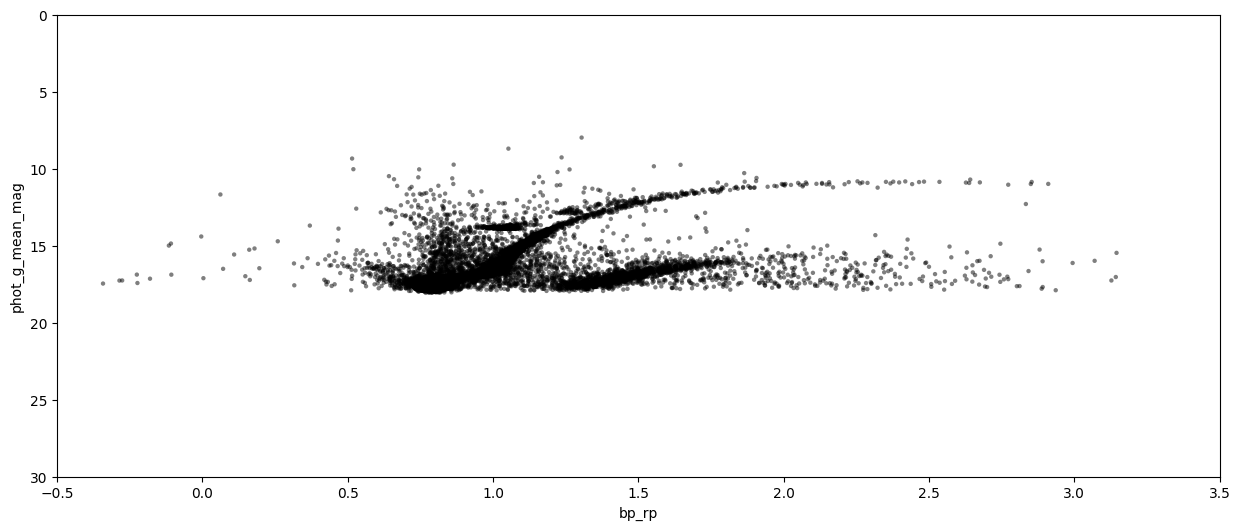

In [185]:
dfr1 = project.data_list[0].get_data("df_1_c2")

ax, fig = cmd_plot(dfr1, df_iso, isochrone_distance_module=distance_module, isochrone_redding=redding
                  )
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

In [126]:
columns_to_clus=["pmra", "pmdec", "parallax", 
                 'bp_rp', 
                 'phot_g_mean_mag'
                ]
clustering = project.cluster_detection(
    data_name="df_1_c2",
    columns=["pmra", "pmdec", "parallax"], 
    columns_to_clus=columns_to_clus,
    max_cluster=10,
    method="hdbscan",
    n_trials=100
)
print(str(project.clustering_results))

[I 2025-04-20 21:43:43,176] A new study created in memory with name: no-name-5dec7046-517d-41cb-becd-485a3d150a30
[I 2025-04-20 21:43:45,579] Trial 0 finished with value: 0.10215162211790109 and parameters: {'min_cluster_size': 97, 'min_samples': 7}. Best is trial 0 with value: 0.10215162211790109.
[I 2025-04-20 21:43:47,790] Trial 1 finished with value: 0.10350048304420562 and parameters: {'min_cluster_size': 60, 'min_samples': 5}. Best is trial 0 with value: 0.10215162211790109.
[I 2025-04-20 21:43:50,031] Trial 2 finished with value: 0.10215162211790109 and parameters: {'min_cluster_size': 34, 'min_samples': 7}. Best is trial 0 with value: 0.10215162211790109.
[I 2025-04-20 21:43:52,307] Trial 3 finished with value: 0.10350048304420562 and parameters: {'min_cluster_size': 22, 'min_samples': 5}. Best is trial 0 with value: 0.10215162211790109.
[I 2025-04-20 21:43:54,754] Trial 4 finished with value: 0.10252376164825407 and parameters: {'min_cluster_size': 33, 'min_samples': 6}. Best 

Estimated number of clusters: 6
Estimated number of noise points: 4446
	 - Volumen total del cluster 0: 19.
	 - Volumen total del cluster 1: 292.
	 - Volumen total del cluster 2: 2982.
	 - Volumen total del cluster 3: 18.
	 - Volumen total del cluster 4: 12483.
	 - Volumen total del cluster 5: 24.



In [127]:
print(str(project.clustering_results))

Estimated number of clusters: 6
Estimated number of noise points: 4446
	 - Volumen total del cluster 0: 19.
	 - Volumen total del cluster 1: 292.
	 - Volumen total del cluster 2: 2982.
	 - Volumen total del cluster 3: 18.
	 - Volumen total del cluster 4: 12483.
	 - Volumen total del cluster 5: 24.



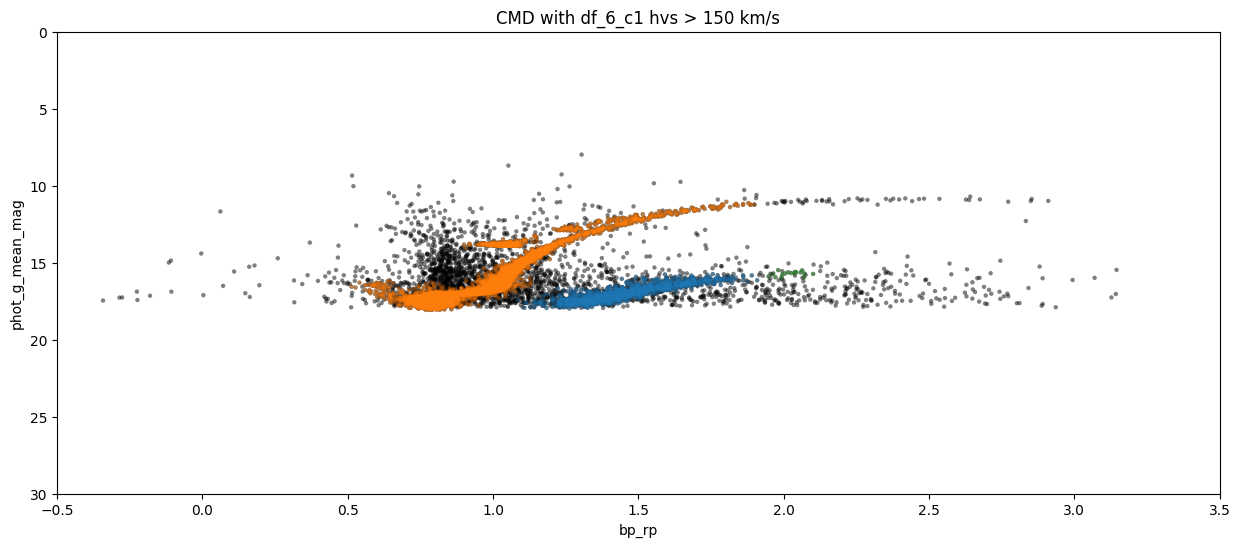

In [186]:
fig, ax = project.plot_cmd(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 0.0,
            hvs_pm = 150,
            df_isochrone = df_iso,
            isochrone_distance_module=distance_module, 
            isochrone_redding=redding,
            legend=False
)
ax.set_xlim(-0.5, 3.5)
ax.set_ylim(30, 0)
plt.show()

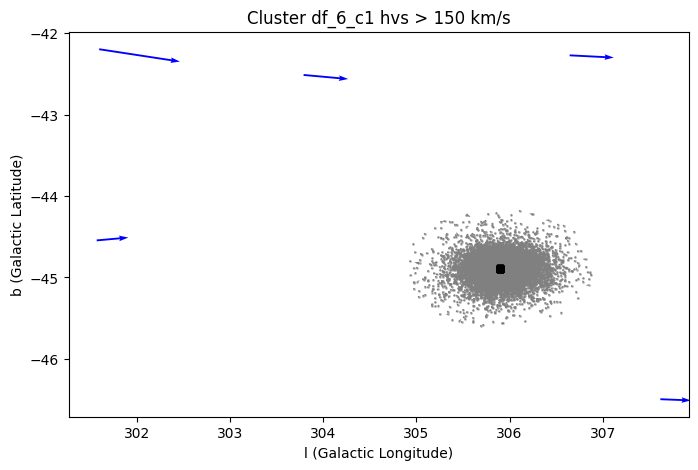

In [192]:
fig, ax = project.plot_cluster(
            hvs_candidates_name="df_6_c1",
            factor_sigma = 1,
            hvs_pm = 150,
            legend=False,
            factor_size=50
)
plt.show()

In [188]:
mask = project.clustering_results.labels == get_main_cluster(project.clustering_results.labels)
gc = project.clustering_results.gc

print("Número de estrellas de CLuster seleccionado: %d" % gc.shape[0])
print("Número de HVS del CLuster seleccionado: %d" % gc[gc.pm_kms>200].shape[0])
display(gc[["pmra", "pmdec", "parallax", "radial_velocity"]].describe())

Número de estrellas de CLuster seleccionado: 12797
Número de HVS del CLuster seleccionado: 2498


,pmra,pmdec,parallax,radial_velocity
count,12797.000000,12797.000000,12797.000000,1125.000000
mean,5.251557,-2.574233,0.195411,-17.202012
std,0.374576,0.384599,0.077816,10.794205
min,3.059615,-4.270577,-0.227476,-119.478880
25%,5.006763,-2.840394,0.153701,-22.466637
50%,5.249858,-2.579028,0.195637,-17.118820
75%,5.493504,-2.306996,0.235677,-12.428101
max,7.347773,-0.871430,0.564312,98.392784


In [131]:
gc = project.clustering_results.gc
gc.columns.values

array(['solution_id', 'DESIGNATION', 'SOURCE_ID', 'random_index',
       'ref_epoch', 'ra', 'ra_error', 'dec', 'dec_error', 'parallax',
       'parallax_error', 'parallax_over_error', 'pm', 'pmra',
       'pmra_error', 'pmdec', 'pmdec_error', 'ra_dec_corr',
       'ra_parallax_corr', 'ra_pmra_corr', 'ra_pmdec_corr',
       'dec_parallax_corr', 'dec_pmra_corr', 'dec_pmdec_corr',
       'parallax_pmra_corr', 'parallax_pmdec_corr', 'pmra_pmdec_corr',
       'astrometric_n_obs_al', 'astrometric_n_obs_ac',
       'astrometric_n_good_obs_al', 'astrometric_n_bad_obs_al',
       'astrometric_gof_al', 'astrometric_chi2_al',
       'astrometric_excess_noise', 'astrometric_excess_noise_sig',
       'astrometric_params_solved', 'astrometric_primary_flag',
       'nu_eff_used_in_astrometry', 'pseudocolour', 'pseudocolour_error',
       'ra_pseudocolour_corr', 'dec_pseudocolour_corr',
       'parallax_pseudocolour_corr', 'pmra_pseudocolour_corr',
       'pmdec_pseudocolour_corr', 'astrometric_matche

## Referencias
- Kızıltan, B., Baumgardt, H., & Loeb, A. (2017). An intermediate-mass black hole in the centre of the globular cluster 47 Tucanae. Nature, 542(7640), 203-205.